In [1]:
#LIBRARIES, TOOLS (still have extras here prob.)
#ABSOLUTE FIRST THING TO RUN 
import numpy as np 
from astropy.io import fits
import matplotlib.pyplot as plt
import array 
import pylab 
import pyphot
from pyphot import Filter
from pyphot import Library
from pyphot import Ascii_Library
import math 
from pyphot import ezunits
import struct
import os
import glob
import itertools 
from itertools import cycle
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import random 
from random import choices 
import re
from astropy.table import Table, Column
import tables
from tables import *
import re 
import heapq
from statistics import *
from matplotlib.backends.backend_pdf import PdfPages
current = os.getcwd() #get current working directory 
from multiprocessing import Pool
from multiprocessing import Process

#USE FOR SPECTRA
def txtfile(tfilename):

    tdul = np.genfromtxt(tfilename,skip_header = 47)
    wlen = tdul[:,0]
    mag = tdul[:,1]
    wlen = wlen[mag!=-999]
    mag = mag[mag!=-999]
    
    return wlen, mag

#USE FOR FILTERS NOT ALREADY IN PYPHOT
def txtfile2(tfilename):
    tdul = np.genfromtxt(tfilename)
    wlen = tdul[:,0]
    mag = tdul[:,1]
    wlen = wlen[mag!=-999]
    mag = mag[mag!=-999]
    
    return wlen, mag

#USE FOR ALL SPECTRA 
def fitsfile(ffilename):
    hdul = fits.open(ffilename)
    data = fits.getdata(ffilename)
    wave = data[0,:]
    fluxden = data[1,:]
     
    a = float('nan')
    wave = wave[fluxden!=a]
    fluxden = fluxden[fluxden!=a]
    return wave, fluxden

#GETS THE ERROR OUT OF SPECTRA FILE
def spectraError(tfilename):
    tdul = np.genfromtxt(tfilename,skip_header = 47)
    mag = tdul[:,1]
    error = tdul[:,2]
    error = error[mag!=-999]
    
    return error

#DEFINES THE LOWER BOUND OF SPECTRAL FLUX DENSITY
def lowerBound(filename):
    error = spectraError(filename)
    wave, fluxden = txtfile(filename)
    lower = fluxden - error
    return wave, lower 

#DEFINES UPPER BOUND OF SPECTRAL FLUX DENSITY 
def upperBound(filename):
    error = spectraError(filename)
    wave, fluxden = txtfile(filename)
    upper = fluxden + error
    return wave, upper

#SIMULATE A MONTE CARLO ERROR RUN 
#filename needs to be a string, file needs to be an array of strings 
def monteCarlo(file, sampleSize,iterations):
    error = spectraError(file)
    error1 = np.array(error).tolist()
    errora = -1 * error
    error2 = np.array(errora).tolist()
    errorComposite = error1 + error2 
    monteArray = []
    avgArray = []
    for _ in range(0,iterations):
        monteError = np.asarray(random.choices(errorComposite, weights=None, cum_weights=None, k=sampleSize))
        avgErr = np.asarray(float((sum(monteError)) / (len(monteError))))
        #print(monteError)
        #print(avgErr)
        monteArray.extend(monteError)
        avgArray.append(avgErr)
    return monteArray, avgArray   
    

#OPENS AND READS DATA OF STRINGS AND FLOATS 
#used primarily in here for getting filter names with calculated flux zeropts from SOV 
def datafile(filename):
    f=open(filename,"r")
    lines=f.readlines()
    result=[]
    for x in lines:
        result.append(x.split(' ')[0])
        filters = np.asarray(result)
    f.close()
    
    tdul = np.genfromtxt(filename)
    fluxes = tdul[:,1]
    
    return filters, fluxes

def extendeddatafile(filename):
    f=open(filename,"r")
    lines=f.readlines()
    result=[]
    for x in lines:
        result.append(x.split(' ')[0])
        spectrafits = np.asarray(result)
    f.close()
    
    tdul = np.genfromtxt(filename)
    hmags = tdul[:,1]
    jmags = tdul[:,2]
    ksmags = tdul[:,3]
    
    return spectrafits, hmags, jmags, ksmags

def useFitsdata(filename):
    hdulist = fits.open(filename)
    hdu = hdulist[0]
    return hdu.header['H'], hdu.header['HERR'], hdu.header['J'], hdu.header['JERR'], hdu.header['KS'], hdu.header['KSERR']

In [ ]:

def inputsCalc(filter, wave, flux):
    wave = wave * 10e3 #standardized to A
    flux = flux * 10e-2 #standardized to A^(-1)
    fluxes = filter.get_flux(wave, flux, axis=-1) #for some reason, using fits file data produces nan
    RegMags = -2.5 * np.log10(fluxes) - filter.Vega_zero_mag
    return RegMags

def inputsCalc2(filter, wave, flux):
    fluxes = filter.get_flux(wave, flux, axis=-1) #for some reason, using fits file data produces nan
    RegMags = -2.5 * np.log10(fluxes) - filter.Vega_zero_mag
    return RegMags

In [ ]:

def monteFiles1(filter,file,rounds):
    magnitudes = []
    wave, mag = txtfile(file)    
    for _ in range (0,rounds):
        monte, avg = monteCarlo(file, len(mag),1)
        newFlux = mag + monte
        #print(newFlux)
        magnitude = inputsCalc(filter,wave,newFlux)
        magnitudes.append(magnitude)
    #print('magnitudes = ' + str(magnitudes))
    return magnitudes

In [2]:
#SECOND SECTION TO RUN 
#get the internal default library of passbands filters
# establishes desired filters as the ones we want to analyze
lib = pyphot.get_library()
print("Library contains: ", len(lib), " filters")
# find all filter names that relates to IRAC
# and print some info
f = lib.find('JWST_NIRCam')
g = lib.find('2MASS')
hi = lib.find('HST_WFC3')
h = hi[0:15]

#test that we see everything is in library 
for name in f:
    lib[name].info(show_zeropoints=True)

Library contains:  243  filters
Filter object information:
    name:                 JWST_NIRCAM_F070W
    detector type:        photon
    wavelength units:     um
    central wavelength:   0.706178 micrometer
    pivot wavelength:     0.704322 micrometer
    effective wavelength: 6955.948963 micrometer
    norm:                 0.032808
    definition contains 2050 points

    Zeropoints
        Vega: 21.933915 mag,
              1.6843571835368132e-09 erg / angstrom * centimeter ** 2 * second,
              2.7871200559206776e-05 Jy
          AB: 21.646804 mag,
              2.1942116502569344e-09 erg / angstrom * centimeter ** 2 * second,
              3.630780547701003e-05 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-09 erg / angstrom * centimeter ** 2 * second,
              6.007883234062841e-05 Jy
        
Filter object information:
    name:                 JWST_NIRCAM_F090W
    detector type:        photon
    wavelength units:     um
    central waveleng

Filter object information:
    name:                 JWST_NIRCAM_F277W
    detector type:        photon
    wavelength units:     um
    central wavelength:   2.769490 micrometer
    pivot wavelength:     2.761872 micrometer
    effective wavelength: 27131.777480 micrometer
    norm:                 0.280904
    definition contains 2535 points

    Zeropoints
        Vega: 26.903135 mag,
              1.7327910189532542e-11 erg / angstrom * centimeter ** 2 * second,
              4.4089240657800926e-06 Jy
          AB: 24.613966 mag,
              1.4269658154643897e-10 erg / angstrom * centimeter ** 2 * second,
              3.630780547700996e-05 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-09 erg / angstrom * centimeter ** 2 * second,
              0.0009238180230178711 Jy
        
Filter object information:
    name:                 JWST_NIRCAM_F300M
    detector type:        photon
    wavelength units:     um
    central wavelength:   2.990913 micrometer
    p


    Zeropoints
        Vega: 29.068781 mag,
              2.3576946033231957e-12 erg / angstrom * centimeter ** 2 * second,
              1.6856182850656027e-06 Jy
          AB: 25.735679 mag,
              5.078416495008732e-11 erg / angstrom * centimeter ** 2 * second,
              3.630780547701001e-05 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-09 erg / angstrom * centimeter ** 2 * second,
              0.0025958027267988628 Jy
        
Filter object information:
    name:                 JWST_NIRCAM_F466N
    detector type:        photon
    wavelength units:     um
    central wavelength:   4.654441 micrometer
    pivot wavelength:     4.654405 micrometer
    effective wavelength: 46539.235479 micrometer
    norm:                 0.017661
    definition contains 2236 points

    Zeropoints
        Vega: 29.123266 mag,
              2.2422991868707064e-12 erg / angstrom * centimeter ** 2 * second,
              1.6203217913647988e-06 Jy
          AB: 25.747

In [3]:
#THIRD TO RUN 
#sets up all of the filters we want to use in the same set from the default internal library 
theseFilters = g+h #perhaps split this up so that we can compare 2mass stuff to everything else
i = lib[theseFilters]
twomass = lib[g]
hst = lib[h]
jwst = lib[f]

In [4]:
#FOURTH TO RUN 
#sets up our database of spectral files we are using (from working in the directory I set up of them)
file = os.listdir(current) #determines how many files we need to go through
thisFile = glob.glob("*star.txt")#change end of names of files (make this call easier) 
tFarray = np.asarray(thisFile)#converts to array for indexing 
fitsfiles = glob.glob("*.fits")
fitsarray = np.asarray(fitsfiles)
GKM = tFarray[15:]
Fstars = tFarray[0:15]
Gstars = tFarray[15:38]
Kstars = tFarray[38:64]
Mstars = tFarray[64:]
GKMstars = [Gstars, Kstars, Mstars]
FGKMstars = [Fstars, Gstars, Kstars, Mstars]
FGKstars = [Fstars, Gstars, Kstars]
print(len(GKMstars))

3


In [ ]:
print(Mstars[0])

In [14]:
#data directly from the files on calculated magnitudes and error for H, J and Ks, respectively 
def firstError(fits):
    for fit in range(0,len(fits)):
        
        
        a, b, c, d, e, f = useFitsdata(fits[fit])
        print(fits[fit] + '  ' + str(a) + '  '  + str(c) + '  ' + str(e))
        #print('upper and lower bounds : ' + str(a+b) + ' , ' + str(a-b) + ' , ' + str(c+d) + ' , ' + str(c-d) + ' , '
             # + str(e+f) + ' , ' + str(e-f))
        #return a, b, c, d, e, f, a+b, a-b, c+d, c-d, e+f, e-f

In [ ]:
firstError(fitsarray)

In [15]:
#gets the fitserror data into something interpretable 
spe, hma, jma, ksma = extendeddatafile('rawData.txt')
hma = np.array(hma).tolist()
jma = np.array(jma).tolist()
ksma = np.array(ksma).tolist()        

In [5]:
#FIFTH TO RUN 
#the only two filters not in the pyphot module
#ran into an error where I accidentally erased the pyphot filters when I tried to add them, so I'm just working with these two separately
#also set up a short array so that we can loop through these as well 
w, fill = txtfile2('HST_WFC3_G102.txt') 
HST_WFC3_G102 = Filter(w, fill, name='HST_WFC3_G102', dtype="photon", unit='Angstrom')

w2, f2 = txtfile2('HST_WFC3_G141.txt')
HST_WFC3_G141 = Filter(w2, f2, name= 'HST_WFC3_G141', dtype="photon", unit='Angstrom')

newFilters = HST_WFC3_G102.name + HST_WFC3_G141.name
newFiltersarray = np.asarray(newFilters)

j1, j2 = txtfile2('2MASS_J.txt')
twoMass_J = Filter(j1,j2, name= '2MASS_J1', dtype="photon", unit='Angstrom')
newJ = [twoMass_J]

In [ ]:
colors(twoMass_J,twomass[0], magnitudeCalc, [hstForh[2]], magnitudeCalc, hstForj[0], magnitudeCalc, 9)

In [ ]:
mag_mag_delta(magnitudeCalc,[hstForj[0]],twoMass_J)

In [ ]:
def central_wavelengths(filterlibrary): 
    cl = []
    cln = []
    for cllen in range(0,len(filterlibrary)):
        center = filterlibrary[cllen].cl.magnitude
        centername = filterlibrary[cllen].name
        cl.append(center)
        cln.append(centername)
    return cl, cln

def central_wavelengths_jwst(filterlibrary):
    cl = []
    cln = []
    for cllen in range(0,len(filterlibrary)):
        center = filterlibrary[cllen].cl.magnitude
        center = center * 10e3
        centername = filterlibrary[cllen].name
        cl.append(center)
        cln.append(centername)
    return cl, cln

In [ ]:
#compare hst and jwst to h and j, and compare jwst to ks 
clh, clnh = central_wavelengths(twomass)
clhst, clnhst = central_wavelengths(hst)
cljwst, clnjwst = central_wavelengths_jwst(jwst)


In [ ]:
def findCloseFilt(filterlibrary, function):
    char = "(\d+)([N])"
    cl2, cln2 = central_wavelengths(twomass)
    cl, cln = function(filterlibrary)
    for tm in range(0,len(cl2)): 
        diffArray = abs(cl2[tm]-cl)
        for dif in range(0,len(diffArray)):
            if (diffArray[dif] < 1.25 * 10e2):
                #print(str(cln[dif]) + ' is compatible with ' + str(cln2[tm])) 
                if re.search(char,cln[dif]):
                    print('',end="")
                else: 
                    print(str(cln[dif]) + ' is compatible with ' + str(cln2[tm]))


In [ ]:
char = "(\d+)" 
print(str(twomass))

In [ ]:
print((findCloseFilt(hst,central_wavelengths)))#2MASS TO HST
print((findCloseFilt(jwst,central_wavelengths_jwst))) #2MASS TO JWST

#ignore filters that have N in them 
#can calculate numerically by subtracting first nonzero element and last: less than 300A eliminate 
#above: used character-searching since pyphot does not already have the min & max

In [10]:
#non-narrow-band filters 
hstForh = [hst[5],hst[11],hst[12]]
hstForj = [hst[2],hst[3]]
jwstForh = [jwst[5],jwst[6]]
jwstForj = [jwst[2]]
jwstForks = [jwst[11]]
composite = [hst[2],hst[3],hst[5],hst[11],hst[12],jwst[2],jwst[5],
            jwst[6],jwst[11],jwst[12],twomass[0],twomass[1],twomass[2]]

Forj = [hst[2],hst[3],jwst[2]]
Forh = [hst[5],hst[11],hst[12],jwst[5],jwst[6]]
#composite will be used to simulate monte-carlo. otherwise, mag_mag will call for the smaller arrays to use w/ 
#appropriate 2mass filter in plotting 

In [ ]:
#reference for magnitdes in 2mass filters, to compare to the IRTF data
for this in range(0,len(twomass)):
    for that in range(0,len(GKMstars)):
        magCalc(twomass[this],GKMstars[that])

In [8]:
#CALCULATES MAGNITUDES (magnitudeCalc for 2mass, hst and magnitudecalc2 for jwst)
def magnitudeCalc(filter,spectra):
    magnitudes = []
    for x in range(0,int(len(spectra))):
        
        w, f = txtfile(spectra[x]) #gets all of the data we need for ea. file [x]
        w = w * 10e3 #standardized to A
        f = f * 10e-2 #standardized to A^(-1)
        fluxes = filter.get_flux(w, f, axis=-1) #for some reason, using fits file data produces nan 
        RegMags = -2.5 * np.log10(fluxes) - filter.Vega_zero_mag
        magnitudes.append(RegMags)
    return magnitudes 

def magnitudeCalc2(filter,spectra):
    magnitudes = []
    for x in range(0,int(len(spectra))):
        
        w, f = txtfile(spectra[x]) #gets all of the data we need for ea. file [x]
        fluxes = filter.get_flux(w, f, axis=-1) #for some reason, using fits file data produces nan 
        RegMags = -2.5 * np.log10(fluxes) - filter.Vega_zero_mag
        magnitudes.append(RegMags)
    return magnitudes 
        

In [ ]:
#simpler to print
charac = 'JWST'
def easierCalc(filter, spectra):
    for gg in range(0,len(spectra)):
        wave, flux = txtfile(spectra[gg])
        if re.search(charac,filter.name):
            wave = wave
            flux = flux 

        else:
            wave = wave * 10e3 #standardized to A
            flux = flux * 10e-2 #standardized to A^(-1)

        fluxes = filter.get_flux(wave, flux, axis=-1) #for some reason, using fits file data produces nan
        RegMags = -2.5 * np.log10(fluxes) - filter.Vega_zero_mag
        print(str(filter.name) + ','+ str(spectra[gg])+ ',' + str(RegMags))
        #print(spectra[gg])
        #print(RegMags)
        for sp in range(0,2):
            print('')

In [ ]:
print((twomass[0].name))

In [ ]:
easierCalc(twomass[2],tFarray)
#WORK OUT FILE-WRITING TO GET MAGNITUDES IN A READABLE DOCUMENT ACROSS ALL FILTERS AND ALL SPECTRA  
#

In [ ]:
#magFuncHst_Jwst = magnitudeCalc for HST, magnitudeCalc2 for JWST
#Hst_Jwst = any of the arrays I set up to correspond to the twoMass arrays
#twoMass = either twomass[0](h), twomass[1](j), or twomass[2](ks)
#maybe put errors that pop up when I try an incorrect combination of any of the three above
markers = ['o', 'p', 's', '*']
markercycle = cycle(markers)
size = [240,170,100,30]
sizecycle = cycle(size)
color = 'mcbr'


In [ ]:
#F160W = hstForh[2], F110W = hstForj[0]
#modified version of color method, except takes in input arguments for four filters and plots accordingly 

In [ ]:
def colors(twoMass, twoMass2, magFuncHst_Jwst0, Hst_Jwst, magFuncHst_Jwst, twoMass3, magFuncHst_Jwst2, location):
    FGKM = ['F stars','G stars','K stars','M stars']
    
    for theseFilt in range(0,len(Hst_Jwst)):
        
        #amasses all magnitudes across G,K,M-type stars for ea. type of filter
        mtmass = []
        mt2mass = []
        mhmass = []
        mdmass = []
        md2mass = []
        twodmass = []    
        ultramass = []
            
        for theseStars in range(0,len(FGKMstars)):
            #initializes arrays used in calculating magnitude, will iterate for F, G, K separately 
            mt = []
            mt2 = []
            mh = []
            md = []
            md2 = []
            twod = []
            ultra = []
            
            #magnitude calculation for ea. filter and calculating the difference
            magnitwo = magnitudeCalc(twoMass,FGKMstars[theseStars])
            magnitwo2 = magFuncHst_Jwst0(twoMass2, FGKMstars[theseStars])
            magnihst = magFuncHst_Jwst(Hst_Jwst[theseFilt],FGKMstars[theseStars])
            magnitwo3 = magFuncHst_Jwst2(twoMass3,FGKMstars[theseStars])
                
            #magnidiff1 = [magnitwo - magnitwo3 for magnitwo, magnitwo3 in zip(magnitwo,magnitwo3)] 
            magnidiff1 = [magnitwo3 - magnihst for magnitwo3, magnihst in zip(magnitwo3,magnihst)] 
            twoDiff = [magnitwo - magnitwo2 for magnitwo, magnitwo2 in zip(magnitwo,magnitwo2)]
            #magnidiff2 = [magnitwo2 - magnihst for magnitwo2, magnihst in zip(magnitwo2,magnihst)]
            #ultraDiff =  [twoDiff - magnidiff1 for twoDiff, magnidiff1 in zip(twoDiff,magnidiff1)]
            #ultraDiff = [magnidiff1 - magnidiff2 for magnidiff1,magnidiff2 in zip(magnidiff1,magnidiff2)]
            ultraDiff =  [magnidiff1 - twoDiff for magnidiff1, twoDiff in zip(magnidiff1,twoDiff)]
            
            #for ea. class of star
            mt.append(magnitwo)
            mt2.append(magnitwo2)
            mh.append(magnihst)
            md.append(magnidiff1)
            #md2.append(magnidiff2)
            twod.append(twoDiff)
            ultra.append(ultraDiff)
            
            #format needed to analyze linear model 
            mda = np.asarray(md[0])
            tda = np.asarray(twod[0])
            uda = np.asarray(ultra[0])
            
            #linear regression in ea. type of filter and diff for ea. class of star
            #regsth = np.polyfit(tda,mda,1)
            regsth = np.polyfit(tda,uda,1)
            
            #printing ea. linear regression of mag-mag and both delta-mag-mag functions, for ea. class of star 
            print(str(FGKM[theseStars]) + ' ' + str(twoMass.name) + ' - ' + str(Hst_Jwst[theseFilt].name) + ' ' + str(twoMass.name) + ' - ' + str(twoMass2.name) + ' color fit = ' + str(regsth))
  
            #iterates so that the markers between F,G,K,M on ea. graph are diff. Othe graph properties 
            #plt.scatter(twod, md, s=size[theseStars], marker = markers[theseStars], c=color[theseStars],alpha = 0.23, label=FGKM[theseStars])
            plt.scatter(twod,ultra,s=size[theseStars], marker = markers[theseStars], c=color[theseStars],alpha = 0.23, label=FGKM[theseStars])
            
            #masses all magnitudes and diff calculations across F,G,K,M stars
            if(theseStars !=3):    
                twodmass.extend(twoDiff)
                mdmass.extend(magnidiff1)
                ultramass.extend(ultraDiff)
                
        #fitting = np.polyfit(np.asarray(twodmass),np.asarray(mdmass),1)
        fitting = np.polyfit(np.asarray(twodmass),np.asarray(ultramass),1)
        #plt.plot(np.unique(twodmass), np.poly1d(np.polyfit(np.asarray(twodmass),np.asarray(mdmass),1))(np.unique(twodmass)), label='y=' + str("%.4f" % fitting[0]) + '*x' + ' + ' + str("%.4f" % fitting[1]))
        plt.plot(np.unique(twodmass), np.poly1d(np.polyfit(np.asarray(twodmass),np.asarray(ultramass),1))(np.unique(twodmass)), label='y=' + str("%.4f" % fitting[0]) + '*x' + ' + ' + str("%.4f" % fitting[1]))
        zcolor = np.zeros(len(twodmass))
        zcolor = zcolor + fitting[1]
        plt.plot(twodmass,zcolor,label='y = '  + str("%.4f" % fitting[1]))
        
        #linear regression for entire graph
        print('')
        print('all spectra ' + str(twoMass.name) +  ' - ' + str(Hst_Jwst[theseFilt].name) + str(twoMass.name) + ' - ' + str(twoMass2.name) + ' color fit = ' + str(fitting))
        
        #sets limits so we can see what's going on 
        #plt.ylim((min(mdmass)-0.1),(max(mdmass)+0.1))
        plt.ylim((min(ultramass)-0.025),(max(ultramass)+0.025))
        plt.xlim((min(twodmass)-0.025),(max(twodmass)+0.025)) 
        plt.xlabel('(' +str(twoMass.name) + ' - ' + str(twoMass2.name) + ')', fontsize=9)
        #plt.ylabel(str(twoMass3.name) + ' - ' + str(Hst_Jwst[theseFilt].name), fontsize=9)
        plt.ylabel('(' + str(twoMass.name) + ' - ' + str(twoMass2.name) + ') ' + ' - ' + ' (' + str(twoMass3.name) + ' - ' + str(Hst_Jwst[theseFilt].name) + ')', fontsize=9)
        plt.legend(loc=location, bbox_to_anchor=(0.5, 1), ncol=3)
        
        pdfgraphic.savefig()
        plt.show()
        
        
    
    

In [ ]:
#NEW GOOD CALLS:
#J-'Jx'
#H-'Hx'
#Ks-'Ks'
#magnitwo = magnitwo3
#magnitwo2, magnihst will be used for hst/jwst filters interchangeably 
pdfgraphic = PdfPages('newGraphs3.pdf')
colors(twomass[1], twomass[0], magnitudeCalc, [hstForh[2]], magnitudeCalc, hstForj[0], magnitudeCalc, 9)
pdfgraphic.close()

In [ ]:
#filter combos: J-H with j-j-like and h-h-like, J-K with j-j-like and k-k-like

tm_withoutJ = [twomass[0],twomass[2]]
tm_withoutH = [twomass[1],twomass[2]]
tm_withoutKs = [twomass[0],twomass[1]]


In [ ]:
HLike = [hstForh[2]]
print(hstForj)
print(len(tFarray))

In [ ]:
#make below a definition, and then run for:
#twomass[0], hstForh[2], twomass[1], hstForj[0]
def standarddev(filter,stars):
    erbararray = []
    for aran in range(0,len(stars)):
        magma = monteFiles1(filter,stars[aran],1000)
        stdevi = stdev(magma)
        erbararray.append(stdevi)
    return erbararray

In [ ]:
twoher = standarddev(twomass[0],tFarray[0:2])

In [ ]:
#print(twoher)
print(len(tFarray))


In [ ]:
#ATTEMPT AT OPTIMIZATION 
processes = []
for _ in range(1,1000):
    #p = Process(target=standarddev, args=(twomass[0], tFarray[m]))
    p = Process(target=monteFiles1, args=(twomass[0], tFarray[0],1))
    #print(str(p))
    p.start()
    processes.append(p)
#p.close()
#for p in processes:
#    p.join()

In [ ]:
#ATTEMPT AT OPTIMIZATION 
erbararray = []
for aran in range(0,len(tFarray)):
    magma = monteFiles1(twomass[0],tFarray[aran],1000)
    
    #magsethst = monteFiles1(Hst_Jwst[theseFilt],tFarray[starsstar],1000)
            
    stdevi = stdev(magma)
    print('standard dev for ' + str(tFarray[aran]) + ' = ' + str(stdevi))
    erbararray.append(stdevi)
print(erbararray)
    
    #stdevhst = stdev(magsethst)

In [6]:
#USES MAGNITUDES AND DIFFERENCES, PLOTS ACCORDINGLY
#still need deviations 
def mag_mag_delta(magFuncHst_Jwst, Hst_Jwst, twoMass):
    FGKM = ['F stars','G stars','K stars', 'M stars']
    figfig = plt.figure()
    for theseFilt in range(0,len(Hst_Jwst)):
        
        #amasses all magnitudes across G,K,M-type stars for ea. type of filter
        mtmass = []
        mhmass = []
        mdmass = []
        
        #subplots of mag-mag and the two delta-mag-mag 
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(223)
        ax3 = plt.subplot(224)
        
        for theseStars in range(0,len(FGKMstars)):
            #initializes arrays used in calculating magnitude, will iterate for G, K, M separately 
            mt = []
            mh = []
            md = []
            
            #magnitude calculation for ea. filter and calculating the difference
            magnitwo = magnitudeCalc(twoMass,FGKMstars[theseStars])
            magnihst = magFuncHst_Jwst(Hst_Jwst[theseFilt],FGKMstars[theseStars])
            magnidiff = [magnitwo - magnihst for magnitwo, magnihst in zip(magnitwo,magnihst)] 
            
            
            #for ea. class of star
            mt.append(magnitwo)
            mh.append(magnihst)
            md.append(magnidiff)
            
            #format needed to analyze linear model 
            mta = np.asarray(mt[0])
            mha = np.asarray(mh[0])
            mda = np.asarray(md[0])
            
            #linear regression in ea. type of filter and diff for ea. class of star
            regsth = np.polyfit(mta,mha,1)
            regstd = np.polyfit(mta,mda,1)
            regshd = np.polyfit(mha,mda,1)
            
            #printing ea. linear regression of mag-mag and both delta-mag-mag functions, for ea. class of star 
            print(str(FGKM[theseStars]) + ' ' + str(twoMass.name) + ' ' + str(Hst_Jwst[theseFilt].name) + ' mag-mag slope, intercept = ' + str(regsth))
            print(str(FGKM[theseStars]) + ' ' + str(twoMass.name) + ' mag-delta slope, intercept = ' + str(regstd))
            print(str(FGKM[theseStars]) + ' ' + str(Hst_Jwst[theseFilt].name) + ' mag-delta slope, intercept = ' + str(regshd))
            
            #masses all magnitudes and diff calculations across all three classes of star 
            
            if(theseStars !=3):
                mtmass.extend(magnitwo)
                mhmass.extend(magnihst)
                mdmass.extend(magnidiff)
            
            
            #iterates so that the markers between G,K,M on ea. graph are diff. Othe graph properties 
            ax1.scatter(mt, mh, s=size[theseStars], marker = markers[theseStars], c=color[theseStars],alpha = 0.23, label=FGKM[theseStars])
            ax2.scatter(mt, md, s=size[theseStars], marker = markers[theseStars], c=color[theseStars],alpha = 0.23)
            ax3.scatter(mh, md, s=size[theseStars], marker = markers[theseStars], c=color[theseStars],alpha = 0.23)
            ax1.set_position([0.15, 0.6, 0.8, 0.4])
            ax2.set_position([0.125, 0.1, 0.36, 0.33])
            ax3.set_position([0.625, 0.1, 0.36, 0.33])
        
        #run the monteCarlo simulation to make error
        magnitwo = magnitudeCalc(twoMass,tFarray)
        magnihst = magFuncHst_Jwst(Hst_Jwst[theseFilt],tFarray)
        for starsstar in range(0,len(tFarray)):
            
            magsettwo = monteFiles1(twoMass,tFarray[starsstar],1000)
            magsethst = monteFiles1(Hst_Jwst[theseFilt],tFarray[starsstar],1000)
            
            stdevitwo = stdev(magsettwo)
            stdevhst = stdev(magsethst)
            
            ax1.errorbar(magnitwo,magnihst,xerr=stdevitwo,yerr=stdevhst)
            
        firstfit = np.polyfit(np.asarray(mtmass),np.asarray(mhmass),1)
        secondfit = np.polyfit(np.asarray(mtmass),np.asarray(mdmass),1)
        thirdfit = np.polyfit(np.asarray(mhmass),np.asarray(mdmass),1)
        zeros1 = np.zeros(len(mtmass))
        zeros1 = zeros1 + firstfit[1] 
        zeros2 = np.zeros(len(mtmass))
        zeros2 = zeros2 + secondfit[1]
        zeros3 = np.zeros(len(mhmass))
        zeros3 = zeros3 + thirdfit[1] 
        
        ax1.plot(np.unique(mtmass), np.poly1d(np.polyfit(np.asarray(mtmass),np.asarray(mhmass),1))(np.unique(mtmass)), label='y=' + str("%.4f" % firstfit[0]) + '*x' + ' + ' + str("%.4f" % firstfit[1]))
        ax1.plot(mtmass,zeros1,label='y = ' + str("%.4f" % firstfit[1]))
        ax2.plot(np.unique(mtmass), np.poly1d(np.polyfit(np.asarray(mtmass),np.asarray(mdmass),1))(np.unique(mtmass)), label='y=' + str("%.4f" % secondfit[0]) + '*x' + ' + ' + str("%.4f" % secondfit[1]))
        ax2.plot(mtmass,zeros2,label='y = ' + str("%.4f" % secondfit[1]))
        ax3.plot(np.unique(mhmass), np.poly1d(np.polyfit(np.asarray(mhmass),np.asarray(mdmass),1))(np.unique(mhmass)), label='y=' + str("%.4f" % thirdfit[0]) + '*x' + ' + ' + str("%.4f" % thirdfit[1]))
        ax3.plot(mhmass,zeros3,label='y = ' + str("%.4f" % thirdfit[1]))
        
        #linear regression for entire graph
        print('')
        print('all spectra ' + str(twoMass.name) + ' ' + str(Hst_Jwst[theseFilt].name) + ' mag-mag slope, intercept = ' + str(np.polyfit(np.asarray(mtmass),np.asarray(mhmass),1)))
        print('all spectra ' + str(twoMass.name) + ' mag-delta slope, intercept = ' + str(np.polyfit(np.asarray(mtmass),np.asarray(mdmass),1)))
        print('all spectra ' + str(Hst_Jwst[theseFilt].name) + ' mag-delta slope, intercept = ' + str(np.polyfit(np.asarray(mhmass),np.asarray(mdmass),1)))
        
        #sets limits so we can see what's going on 
        ax1.set_ylim((min(mhmass)-0.1),(max(mhmass)+0.1))
        ax1.set_xlim((min(mtmass)-0.1),(max(mtmass)+0.1)) 
        ax1.set_xlabel(str(twoMass.name), fontsize=9)
        ax1.set_ylabel(str(Hst_Jwst[theseFilt].name), fontsize=9)
        ax1.legend(loc=8, bbox_to_anchor=(0.5, 0.7), ncol=3, prop={'size': 9})
        ax1.text(median(mtmass), (min(mhmass)-2.5), 'variance of mag. dif.= ' + str("%.4f" % variance(mdmass)), fontsize=9)
        
        ax2.set_ylim((min(mdmass)-0.1),(max(mdmass)+0.1))
        ax2.set_xlim((min(mtmass)-0.1),(max(mtmass)+0.1)) 
        ax2.set_xlabel(str(twoMass.name), fontsize=9)
        ax2.set_ylabel(str(twoMass.name) + ' -- ' + str(Hst_Jwst[theseFilt].name), fontsize=9)
        ax2.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 7})
        
        ax3.set_ylim((min(mdmass)-0.1),(max(mdmass)+0.1))
        ax3.set_xlim((min(mhmass)-0.1),(max(mhmass)+0.1)) 
        ax3.set_xlabel(str(Hst_Jwst[theseFilt].name), fontsize=9)
        ax3.legend(loc=9, bbox_to_anchor=(0.5, 1.2), ncol=3, prop={'size': 7})
        #ax3.text(0.5, -0.01, 'variance = ' + str(variance(mdmass)), fontsize=9)
        #ax3.set_ylabel(str(twoMass.name) + '-' + str(Hst_Jwst[theseFilt].name), fontsize=7) 
        #(commented because it shares axis label w/ the other delta-mag-mag graph)
        
        #creates the figure for ea. hst/jwst filter, across G,K,M stars for specified 2mass filter
        #moves on to next hst/jwst filter only when this set is done 
        pdfgraphing.savefig()
        plt.show()
        
        

In [ ]:
pdfgraphing = PdfPages('Mag_color6.pdf')
mag_mag_delta(magnitudeCalc2,[jwstForj[0]],twomass[1])
pdfgraphing.close()

In [ ]:
pdfgraphing = PdfPages('Mag_color1.pdf')
mag_mag_delta(magnitudeCalc,[hstForj[0]],twomass[1])
pdfgraphing.close()

In [ ]:
pdfgraphic = PdfPages('Color-Colr.pdf')
colors(hstForj[0], hstForh[2], magnitudeCalc, [twomass[0]], magnitudeCalc, twomass[1], magnitudeCalc, 9)
pdfgraphic.close()

In [ ]:
pdfgraphing = PdfPages('Mag_color.pdf')
mag_mag_delta(magnitudeCalc,[hstForj[0]],twomass[1])
mag_mag_delta(magnitudeCalc,[hstForj[0]],twoMass_J)
pdfgraphing.close()
pdfgraphic = PdfPages('Color_Color.pdf')
colors(twomass[1], twomass[0], magnitudeCalc, [hstForh[2]], magnitudeCalc, hstForj[0], magnitudeCalc, 9)
colors(twoMass_J, twomass[0], magnitudeCalc, [hstForh[2]], magnitudeCalc, hstForj[0], magnitudeCalc, 9)
pdfgraphic.close()

In [ ]:
pdfgraphing = PdfPages('newGraphs1.pdf')
mag_mag_delta(magnitudeCalc,[hstForj[0]],twomass[1])
mag_mag_delta(magnitudeCalc,[hstForh[2]],twomass[0])
pdfgraphing.close()

In [ ]:
#'#532f53','#2c5349','#3f532a','#532821'
pdfnew = PdfPages('Filter_star_overlay.pdf')

chara = 'JWST'
colo = ['#144853','#0f1953','#53134f','#531411']
fcol = ['#ee942a','#ee522a','#ee2864','#ee43ca','#be39ee','#6b20ee']

def overlaps(twoma, tLike, star): #add star later
    for st in range(0,len(star)):
        xx, yy = txtfile(star[st])
        xx = xx * 10e3
        yy = yy / max(yy)
        plt.plot(xx,yy,linewidth=1,color=colo[st],label=str(re.sub('star.txt', '', str(star[st]))))
    plt.plot(np.asarray(twoma.wavelength),twoma.transmit,color = fcol[5],linewidth=5,label=twoma.name)
    for tL in range(0,len(tLike)):
        wa = np.asarray(tLike[tL].wavelength)
        if re.search(chara,tLike[tL].name):
            wa = wa * 10e3        
        plt.plot(wa,tLike[tL].transmit,color=fcol[tL],label=tLike[tL].name)
        plt.legend(loc='upper right', prop={'size': 7})
        plt.title(str(twoma.name)+ ' , comparable filter ')
        plt.ylabel('transmission')
        plt.xlabel('wavelength (A)')
    plt.xlim(5000,30000)
    pdfnew.savefig()
    plt.show()
        

In [ ]:
overlaps(twomass[0],Forh, [Fstars[0],Gstars[0],Kstars[0],Mstars[0]]) #seems like most/all F stars will work 
overlaps(twomass[1],Forj,[Fstars[0],Gstars[0],Kstars[0],Mstars[0]])
overlaps(twomass[2],jwstForks,[Fstars[0],Gstars[0],Kstars[0],Mstars[0]])

pdfnew.close()

In [ ]:
pdfnew = PdfPages('overlay3.pdf')
overlaps(twomass[1],[Forj[0]], [Fstars[0],Gstars[0],Kstars[0],Mstars[0]])
overlaps(twomass[0],[Forh[2]], [Fstars[0],Gstars[0],Kstars[0],Mstars[0]])
pdfnew.close()

In [ ]:
#test
chara = 'JWST'
for le in range(0,len(composite)):
    wa = np.asarray(composite[le].wavelength)
    if re.search(chara,composite[le].name):
        wa = wa * 10e3        
    plt.plot(wa,composite[le].transmit)
    plt.title(composite[le].name)
    plt.ylabel('transmission')
    plt.xlabel('wavelength (A)')
    plt.show()

In [ ]:
def stars(startypes):
    for st in range(0,len(startypes)):
        xx, yy = txtfile(startypes[st])
        xx = xx * 10e3
        plt.plot(xx,yy,linewidth=1,color=colo[st],label=str(re.sub('star.txt', '', str(startypes[st]))))
    plt.xlim(5000,30000)
    plt.ylabel('flux density (Wm-2um-1)')
    plt.xlabel('wavelength (A)')
    irtf.savefig()
    plt.show()   

In [ ]:
irtf = PdfPages('irtf2.pdf')
stars([Fstars[0],Gstars[0],Kstars[0],Mstars[0]])
irtf.close()

In [ ]:
#MAKING FIGURES ON CHECKLIST
#TRANSMISSION VS WAVELENGTH OF ALL 'J' FILTERS W/ 2MASSJ, SAME FOR H AND KS 


In [ ]:
for ss in range(0,len(tFarray)):
    print(re.sub('star.txt', '', str(tFarray[ss])))
    #for xd in range(0,4):
     #   print('')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   1., 

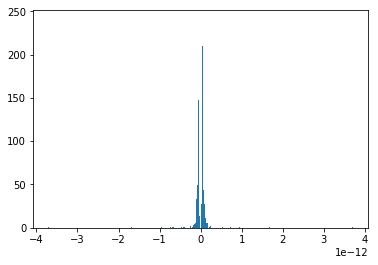

In [18]:
#EXAMPLE OF MONTE CARLO.   
monte, avg = monteCarlo('M9III_IRAS15060+0947star.txt',1,1000)
plt.hist(monte, bins='auto')
#plt.hist(avg, bins ='auto')

In [ ]:
theseMags = monteFiles1(twomass[0],Gstars[3],1000) #need to loop through filters and spectra
print('mean of '+ str(Gstars[starstar]) + ' = '  + str(mean(theseMags)))
print('standard deviation of ' + str(Gstars[starstar]) + ' = '  + str(stdev(theseMags)))

In [ ]:
#test out the simulation
for starstar in range(0,len(Gstars)):
    theseMags = monteFiles1(twomass[0],Gstars[starstar],1000) #need to loop through filters and spectra
    print('standard deviation of '+ str(Gstars[starstar]) + ' = '  + str(stdev(theseMags)))
    #plt.hist(theseMags, bins='auto')
    #plt.show()

In [ ]:
thesemagsAvg = sum(theseMags)/1000
vari = variance(theseMags)
stde = stdev(theseMags)
print(thesemagsAvg)
print(vari)
print(stde)

In [ ]:
#NEED TO WORK ON OPTIMIZING THIS!!! 
#works in theory but takes an incredibly long time to run 
#need to get the pairings of filters that overlap with certain spectra
for r in range(0,len(composite)):
    for s in range(0,len(GKM)):
        theseMags = monteFiles1(composite[r],GKM[s],1000)
        theseMagsAvg = theseMags/1000
        if np.all(np.isfinite(theseMags)):
            plt.hist(theseMags, bins='auto')
            plt.show()

In [ ]:
#first: pick random error values to apply to flux density values
#add and subtract accordingly, so construct 1000 synthetic spectra times for ea. spectrum
#done. then:
# in ea. filter, calculate magnitude (will have 1000 magnitudes for ea. spectrum in ea. filter),
#then determine mean and variance of aforementioned 

In [ ]:
#WORK ON OPTIMIZED VERSION OUTLINED IN PIC AND NOTES 
#TRY TO GET THESE AND MAGNITUDES IN THE SAME DOCUMENT     
    for s in range(0,len(tFarray)):
        theseDeltas = monteCarlo(composite[s],1,1000)
        #build error spectrum based off of this 
        for r in range(0,len(composite)):
            #make magnitude calculation
            #var
            if np.all(np.isfinite(theseMags)):
                plt.hist(theseMags, bins='auto')
                plt.show()


In [ ]:
#deeper lines=-more flux (higher-metal environment) 
#darker bands--should see more error

#TO-DO priority:
#1. fix the error loop to optimize time
#2. print out docs: stellar names, names w/ mags w/ errors


In [ ]:
#gets zeropts from SOV 
names, fluxdata = datafile('SOV_zero_flux.txt') #provides names and zeropts for filters 
theseFiltersarray = np.asarray(theseFilters)

In [ ]:
#TABLE STUFF BELOW. NOT TO WORRY ABOUT NOW 

In [ ]:
input = open('Spectral_Data.txt', 'r')
outfile = open('Spectral_Data.txt', 'w')

In [ ]:
print((theseFilters))
theseFilters1 = theseFilters[0:6]
theseFilters2 = theseFilters[6:13]
theseFilters3 = theseFilters[13:18]

In [ ]:
for spectra in range(0,len(GKM)):
    for filters in range(0,len(theseFilters)):
        contents = {i[filters].name:[(GKM[spectra], mean, median, stdev)]}


In [ ]:
#my attempt to write in the data that i'm processing here. got the two table labels, but need to sort out formattinig and filling in the data
def WritingAFile(fileNo,spectralArray):
    with open('Spectral_Data' + str(fileNo) + '.txt' , 'w') as the_file:
        for x in range(0,len(spectralArray)): 
            the_file.write('                                          ' + spectralArray[x] + '              ')
        for y in range(0,len(GKM)):
            the_file.write('\n')
            GKM[y] = re.sub('star.txt', '', GKM[y])
            the_file.write(GKM[y])
            the_file.write('\n\n\n')#instead of this, fill lines with mean, stdev, median
    
        

In [ ]:
WritingAFile(1,theseFilters1)
WritingAFile(2,theseFilters2)
WritingAFile(3,theseFilters3)